In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

import torch
import torch.nn as nn
from torchvision import transforms, utils
from torchvision import models
from torch.autograd import Variable
from torchvision.utils import make_grid

### 1. Load Image & Labels

(-0.5, 999.5, 999.5, -0.5)

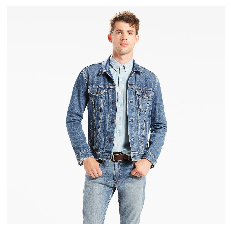

In [2]:
image_path = 'images/test08.jpg'
my_image = Image.open(image_path)
labels = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
classes = {int(key):value for (key, value) in requests.get(labels).json().items()}
plt.imshow(my_image)
plt.axis('off')

### 2. Preprocess Image data

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])
])

### 3. Load model

In [4]:
model = models.vgg19(pretrained=True).cuda()

### 4. SmoothGrad

In [5]:
iteration = 50
add_noise = 0.10

tensor_input = torch.from_numpy(np.array(my_image)).type(torch.cuda.FloatTensor)
final_grad = torch.zeros((1,3,224,224)).cuda()
for i in range(iteration):
    temp_input = tensor_input
    noise = np.random.normal(loc=0, 
                                scale=(add_noise) * (tensor_input.max() - tensor_input.min()).cpu(),
                                size=temp_input.shape)
    noise = torch.from_numpy(noise).type(torch.cuda.FloatTensor)
    temp_input = (temp_input + noise).cpu().numpy()
    temp_input = Image.fromarray(temp_input.astype(np.uint8))
    temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)
    
    output = model.forward(temp_input)
    _, predict_idx = output.data[0].max(0)
    output[0][predict_idx].backward()
    final_grad += temp_input.grad.data[0]
    
grads = final_grad/iteration
grads = grads.clamp(min=0)
grads.squeeze_(0)
grads.transpose_(0,1).transpose_(1,2)
grads = np.amax(grads.cpu().numpy(), axis=2)

### 5. Visualization¶

Text(0.5, 1.0, 'Noise: 0.1%, Samples: 50')

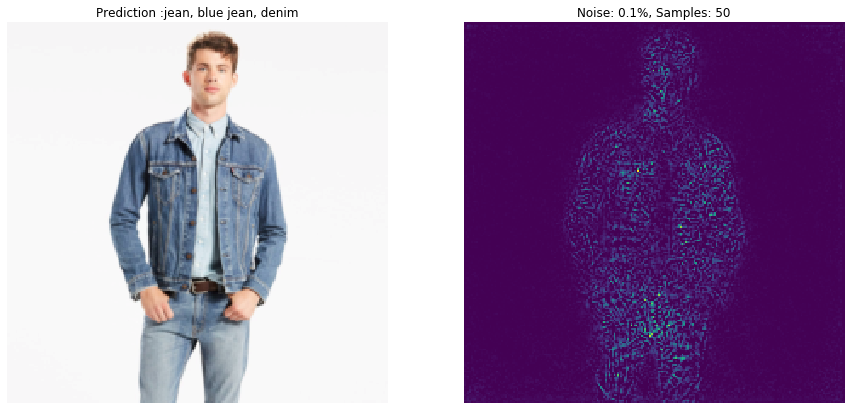

In [7]:
image = preprocess(my_image).cuda()
image = image.squeeze(0).transpose(0,1).transpose(1,2)
image = image*torch.Tensor([0.229, 0.224, 0.225]).cuda()+torch.Tensor([0.485, 0.456, 0.406]).cuda()

fig = plt.figure()
plt.rcParams["figure.figsize"] = (15, 15)

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(image.data.cpu())
plt.title('Prediction :' + classes[predict_idx.item()])
plt.axis('off') 

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(grads)
plt.axis('off') 
plt.title('Noise: ' + str(add_noise) + '%, ' + 'Samples: ' + str(iteration))